# ML_Homework_2

## 1. Data Description

In [1]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd
import numpy as np
import random
import sklearn
import os
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import warnings

def versiontuple(v):
    return tuple(map(int, (v.split("."))))

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
            X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
            warnings.warn('Please update to NumPy 1.9.0 or newer')
        else:
            X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    edgecolor='black',
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
os.chdir('/Users/apple/Desktop/ML_HW2')

In [3]:
df = pd.read_csv('bank.csv', delimiter=';')

In [4]:
df.isnull().any()

age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

There is no missing values in the dataset

### 1.1 Distinguish strings and numerical variables

In [5]:
for i in df:
    print ('%s' %i, type(df[i].iloc[0]))

age <class 'numpy.int64'>
job <class 'str'>
marital <class 'str'>
education <class 'str'>
default <class 'str'>
balance <class 'numpy.int64'>
housing <class 'str'>
loan <class 'str'>
contact <class 'str'>
day <class 'numpy.int64'>
month <class 'str'>
duration <class 'numpy.int64'>
campaign <class 'numpy.int64'>
pdays <class 'numpy.int64'>
previous <class 'numpy.int64'>
poutcome <class 'str'>
y <class 'str'>


* Numerical Varialbes: age, balance, day, duration, campaign, pdays, previous
* Strings Variables: job, marital, education, default, housing, contact, month, poutcome, y
* Month and day should be concatenate into ordinal sequence. Separating them will incerase the training difficulties

We need to transform the categorical variables to numerical expressions

In [6]:
pd.unique(df['month'])

array(['oct', 'may', 'apr', 'jun', 'feb', 'aug', 'jan', 'jul', 'nov',
       'sep', 'mar', 'dec'], dtype=object)

In [7]:
monthdict = {'dec': 12, 'nov': 11,'oct': 10, 'sep': 9,\
             'aug': 8, 'jul': 7, 'jun': 6, 'may': 5,\
             'apr': 4, 'mar': 3, 'feb': 2, 'jan': 1}
timeseq = [monthdict[i] * 100 + j for i, j in zip(list(df['month']), list(df['day']))]
df['time'] = timeseq
df = df.drop(['month', 'day'], axis = 1)

### 1.2 Convert categorical variables

In [8]:
#define a function to convert categorical variables
def convert_cat(col):
    categories = pd.unique(col)
    catcount = len(categories)
    dictvalues = list(range(catcount))
    catdict = dict(zip(categories, dictvalues))
    col = col.map(lambda x : catdict[x])
    return col

In [9]:
cat_features = ['job', 'marital', 'education', 'default', 'loan', 'housing', 'contact', 'poutcome', 'y']

In [10]:
for i in cat_features:
    df[i] = convert_cat(df[i])

### 1.3 Check whether the data set is imbalance

In [11]:
cat = pd.unique(df['y'])

In [12]:
cat

array([0, 1])

In [13]:
print ('percentage of 1: %.2f%%'%(sum(df['y'] == 1) / len(df) * 100))
print ('percentage of 0: %.2f%%'%(sum(df['y'] == 0) / len(df) * 100))

percentage of 1: 11.52%
percentage of 0: 88.48%


Apparently, it is quite an imbalance dataset. Therefore, we need to assign larger weight to '1' label when training

### 1.4 Data descriptions

In [14]:
df.describe()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y,time
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,4.095775,0.498120,1.231365,0.016810,1422.657819,0.566025,0.152842,0.426012,263.961292,2.793630,39.766645,0.542579,0.281132,0.115240,632.593010
std,10.576211,2.602310,0.695471,0.748744,0.128575,3009.638142,0.495676,0.359875,0.614626,259.856633,3.109807,100.121124,1.693562,0.678637,0.319347,238.643077
min,19.000000,0.000000,0.000000,0.000000,0.000000,-3313.000000,0.000000,0.000000,0.000000,4.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,107.000000
25%,33.000000,2.000000,0.000000,1.000000,0.000000,69.000000,0.000000,0.000000,0.000000,104.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,511.000000
50%,39.000000,3.000000,0.000000,1.000000,0.000000,444.000000,1.000000,0.000000,0.000000,185.000000,2.000000,-1.000000,0.000000,0.000000,0.000000,605.000000
75%,49.000000,5.000000,1.000000,2.000000,0.000000,1480.000000,1.000000,0.000000,1.000000,329.000000,3.000000,-1.000000,0.000000,0.000000,0.000000,805.000000
max,87.000000,11.000000,2.000000,3.000000,1.000000,71188.000000,1.000000,1.000000,2.000000,3025.000000,50.000000,871.000000,25.000000,3.000000,1.000000,1231.000000


* The sample volume is 4521
* age, balance, pdays, campagin are features with high variation. It is a good idea to normalize them before training to get higher training speed and higher possibility of reaching the global optimum

## 2. Training

In [15]:
df.columns
y = np.array(df['y'])
features_name = list(df.columns)
features_name.remove('y')

In [16]:
sample_features = random.sample(features_name, len(features_name))
X = np.array(df[sample_features])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [17]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', random_state=1, gamma=0.001, C=5.0, class_weight = {1: 10})#Class_Weight to handle imbalance data
svm.fit(X_train_std, y_train)
from sklearn.metrics import accuracy_score
y_pred = svm.predict(X_test_std)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.80


In [18]:
a = pd.DataFrame({'test': y_test, 'pred': y_pred})
correct_1 = len(a[(a['test'] == 1) & (a['test'] == a['pred'])]) / len(a[(a['test'] == 1)])
correct_0 = len(a[(a['test'] == 0) & (a['test'] == a['pred'])]) / len(a[(a['test'] == 0)])
print ('accuracy of 1: %.2f%%' %correct_1)
print ('accuracy of 0: %.2f%%' %correct_0)

accuracy of 1: 0.79%
accuracy of 0: 0.80%


### 2.2 Consider the best two features

In [19]:
def train(x_train, y_train, x_test, y_test):
    result = []
    svm = SVC(kernel='rbf', random_state=1, gamma=0.001, C=5.0, class_weight = {1: 10})#Class_Weight to handle imbalance data
    svm.fit(x_train, y_train)
    y_pred = svm.predict(x_test)
    result.append(accuracy_score(y_test, y_pred))
    a = pd.DataFrame({'test': y_test, 'pred': y_pred})
    correct_1 = len(a[(a['test'] == 1) & (a['test'] == a['pred'])]) / len(a[(a['test'] == 1)])
    correct_0 = len(a[(a['test'] == 0) & (a['test'] == a['pred'])]) / len(a[(a['test'] == 0)])
    result.append(correct_1)
    result.append(correct_0)
    return result

In [58]:
sample_features = features_name
count = 0
finaldict = {}
for i in sample_features:
    for j in sample_features:
        if i == j:
            continue
        X = np.array(df[[i, j]])
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=1)
        sc = StandardScaler()
        sc.fit(X_train)
        X_train_std = sc.transform(X_train)
        X_test_std = sc.transform(X_test)
        result = train(X_train_std, y_train, X_test_std, y_test)
        print (i, j)
        finaldict[i + '-' + j] = result
        count += 1

/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


default marital
default duration
default contact
default job
default age
default poutcome
default loan
default previous
default time
default housing
default balance
default education
default campaign
default pdays
marital default
marital duration
marital contact
marital job
marital age
marital poutcome
marital loan
marital previous
marital time
marital housing
marital balance
marital education
marital campaign
marital pdays
duration default
duration marital
duration contact
duration job
duration age
duration poutcome
duration loan
duration previous
duration time
duration housing
duration balance
duration education
duration campaign
duration pdays
contact default
contact marital
contact duration
contact job
contact age
contact poutcome
contact loan
contact previous
contact time
contact housing
contact balance
contact education
contact campaign
contact pdays
job default
job marital
job duration
job contact
job age
job poutcome
job loan
job previous
job time
job housing
job balance
job ed

In [59]:
finaldf = pd.DataFrame(finaldict)

In [60]:
finaldf = finaldf.T

In [61]:
finaldf.columns = ['Total Accuracy', 'Accuracy of 1', 'Accuracy of 0']

In [68]:
finaldf[finaldf['Total Accuracy'] > 0.78]

,Total Accuracy,Accuracy of 1,Accuracy of 0
duration-poutcome,0.787767,0.725714,0.796954
poutcome-duration,0.787767,0.725714,0.796954


In [20]:
X = np.array(df[['duration', 'poutcome']])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))




/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


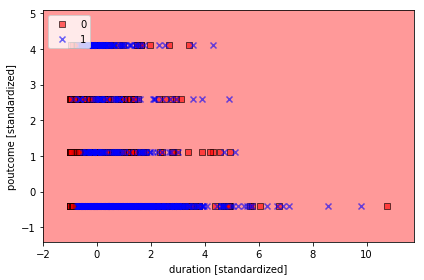

In [21]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.001, C=5.0, class_weight = {1: 10})#Class_Weight to handle imbalance data
svm.fit(X_train, y_train)
X = np.array(df[sample_features])
plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm)
plt.xlabel('duration [standardized]')
plt.ylabel('poutcome [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('./figures/iris_perceptron_scikit.png', dpi=300)
plt.show()